In [147]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}
</style>
""")

# $$\textbf{Python Programming for Machine Learning} $$ 

#### $$\text{WiSe 2020}$$

## $$\text{Lecture 5: Numerical instability, Pandas, Google Colab} $$

#### $$\text{Sergej Dogadov} \quad \text{Philine Thalia Görzig} \quad \text{Panagiotis Tomer Karagiannis}$$

<br><br>
<center>
<img src='./images/pyt.png' width=450>

## $$\textbf{Rounding effect}$$
<hr>
<br>

In [10]:
# First import the required packages
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

* $\text{Let's start with a weird experiment:}$

In [11]:
a = (10**np.arange(4)).astype('float32')
a

array([   1.,   10.,  100., 1000.], dtype=float32)

In [14]:
# Add and subtract the same (huge) number

huge_number = 1e+9  # (10^9) 
assert huge_number == 10**9

(a + huge_number) - huge_number # as you can see the result is not equal a

array([   0.,    0.,  128., 1024.], dtype=float32)

* $ \text{Now, let's repeat the experiment with higher precision (float64):} $

In [15]:
a = (10**np.arange(4)).astype('float64')
a

array([   1.,   10.,  100., 1000.])

In [16]:
huge_number = 1e12

# it seems to work now
(a + huge_number) - huge_number # ok for now it works...

array([   1.,   10.,  100., 1000.])

* $\text{We can also reach the limits of double precision floats (float64):}$

In [17]:
huge_number = 1e18 

print((a + huge_number) - huge_number) # same artefacts appear

[   0.    0.  128. 1024.]


## $$\textbf{Understanding of the rounding effect}$$
<hr>
<br>

In [18]:
# We'll plot all numbers before and after application of the addition and substraction of the huge numbers:
a = np.arange(500).astype('float32')

huge_numbers = [1e7, 1e8, 1e9, 1e10]

In [19]:
def rounding_effect(huge_numbers):
    
    f, axis = plt.subplots(1, len(huge_numbers), sharex=True, sharey=True, figsize = (22,8))
    errors = []
    for i,num in enumerate(huge_numbers):
        ax = axis[i]
        b = (a + num) - num
        ax.plot(a, b, label='rounding')
        errors += [np.abs(a-b).sum()]
        ax.plot(a, a, label=f'truth')
        ax.legend(fontsize=20)

    ttl = axis[1].set_title('Rounding effect', fontsize=25, pad=20)
    axis[0].set_ylabel('after', rotation=0, labelpad=35, fontsize=20)
    xlab = axis[1].set_xlabel('before', fontsize=20, labelpad=10) # pad to get vert dist
    ttl.set_position([1.1,1.0])
    xlab.set_position([1, 0]) # shifting to right (centering)
    
    return errors

['0 -> Error: 0.0',
 '1 -> Error: 998.0',
 '2 -> Error: 8114.0',
 '3 -> Error: 124750.0']

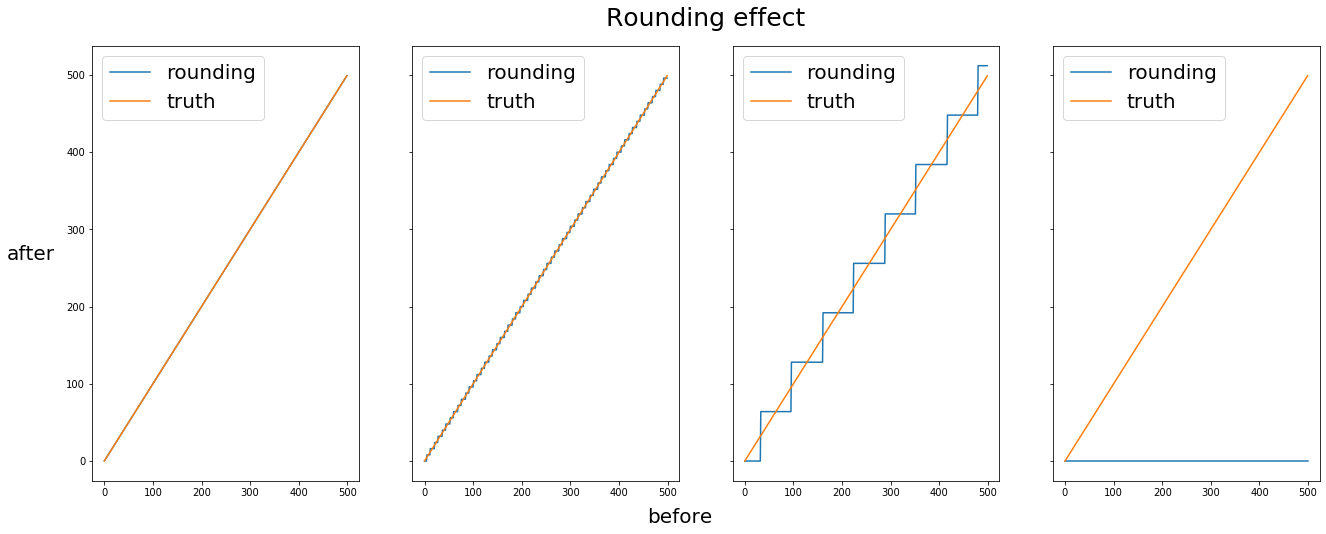

In [20]:
[ f'{num} -> Error: {err}' for num, err in zip(range(len(huge_numbers)), rounding_effect(huge_numbers))]

## $$\textbf{Insights about the rounding effect}$$
<hr>
<br>

* The `float32` and `float64` number representations have a certain budget of bits to represent real numbers.

Therefore, they allocate precision where it is important (e.g. for small numbers).
<br>



* The smaller the precision, the less memory is used and therefore the more efficient (computationally), 

but also the more careful we should be about potential loss of precision.
<br>



* Unlike typical observed data, error is not random-looking, but very structured.

## $$\textbf{Rounding error structure}$$
<hr>
<br>

In [21]:
def rounding_err_structure(val=500, huge_num = 1e+9):

    a = np.arange(val).astype('float32')

    b = (a + huge_num) - huge_num
    error = np.abs(a - b)

    plt.figure(figsize=(14,4))
    plt.plot(a, error)
    plt.title('Rounding error structure', fontsize=25, pad=20)
    plt.xlabel('input number', fontsize=20)
    plt.ylabel('output error', fontsize=20);

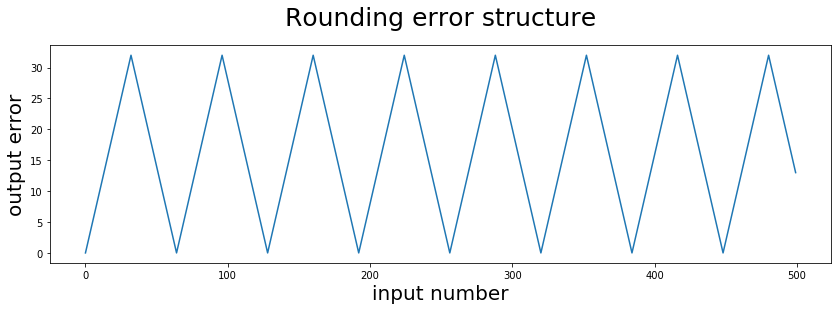

In [22]:
rounding_err_structure()

## $$\textbf{Overflow}$$
<hr>
<br>

* $\text{Overflow is a frequently encountered problem when implementing}$
$ \text{machine learning algorithms.}$

In [23]:
a = 10**np.arange(1,4).astype('float64')
a

array([  10.,  100., 1000.])

In [24]:
# exponential function overflow
np.exp(a)

array([2.20264658e+04, 2.68811714e+43,            inf])

## $$\textbf{Example: sigmoid function}$$
<hr>
<br>

$${\sigma(x) = \frac{e^{x}}{1+e^{x}}}$$

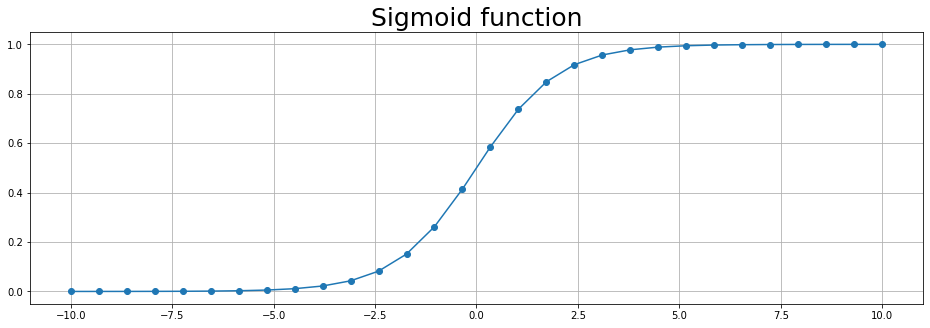

In [25]:
sigmoid = lambda x: np.exp(x) / (1 + np.exp(x))

x = np.linspace(-10, 10, 30)
plt.figure(figsize=(16, 5))
plt.title('Sigmoid function', fontsize=25)
plt.plot(x, sigmoid(x), 'o-')
plt.grid(1)

## $$\textbf{Compute sigmoid function for some values}$$
<hr>
<br> 

In [26]:
x = 10. ** np.arange(0,5)
x = np.sort(np.concatenate([-x, x])) # huge negative and positive numbers
x

array([-1.e+04, -1.e+03, -1.e+02, -1.e+01, -1.e+00,  1.e+00,  1.e+01,
        1.e+02,  1.e+03,  1.e+04])

In [27]:
sigmoid(x)

/home/sdogadov/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.00000000e+00, 0.00000000e+00, 3.72007598e-44, 4.53978687e-05,
       2.68941421e-01, 7.31058579e-01, 9.99954602e-01, 1.00000000e+00,
                  nan,            nan])

* $\text{Where does the `nan` come from?}$

In [28]:
# Undefined mathematical operations

np.inf/np.inf, 0.*np.inf,  np.inf - np.inf

(nan, nan, nan)

In [29]:
# Undefined mathematical operations but works in python be careful !

1.** np.inf, 0.**np.inf, 0.**0

(1.0, 0.0, 1.0)

## $$\textbf{Numerically stable sigmoid function}$$
<hr>
<br> 

* $\text{Let's rewrite the sigmoid function in a different way}$

$$
\sigma(x) = \frac{e^{x}}{1+e^{x}} = \frac{e^{-x} e^{x}}{e^{-x} (1+e^{x})} = \frac{1}{1+e^{-x}}
$$

In [30]:
sigmoid = lambda x: 1./(1 + np.exp(-x))
x

array([-1.e+04, -1.e+03, -1.e+02, -1.e+01, -1.e+00,  1.e+00,  1.e+01,
        1.e+02,  1.e+03,  1.e+04])

In [31]:
sigmoid(x)

array([0.00000000e+00, 0.00000000e+00, 3.72007598e-44, 4.53978687e-05,
       2.68941421e-01, 7.31058579e-01, 9.99954602e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00])

 $\text{This time, we are lucky since 1/inf = 0.0,}$ 
 $\text{which could be the desired result for large negative inputs.}$

## $$\textbf{Robust sigmoid function}$$
<hr>
<br> 

* $\text{The sigmoid function can be written in yet another way using} \> \tanh(x)\> \text{function:}$

$$
\tanh{(x)} = \frac{e^{2x} - 1}{e^{2x} + 1}
$$
<hr>

$$
\sigma(x) = \frac{e^{x}}{1+e^{x}} = \frac{1}{2}\Big(\frac{2e^{x}}{1+e^{x}}\Big) = \frac{1}{2}\Big(\frac{e^{x} - 1 + 1 + e^{x}}{1+e^{x}}\Big) = $$


$$\frac{1}{2}\Big( \frac{e^{x} - 1}{e^{x}+1} + 1\Big) = \frac{1}{2}\Big( \tanh\Big(\frac{x}{2}\Big) + 1\Big)
$$

In [32]:
sigmoid = lambda x: 0.5 * ( np.tanh(0.5 * x) + 1 )

# And there is no runtime warning this time.
sigmoid(x)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.53978687e-05,
       2.68941421e-01, 7.31058579e-01, 9.99954602e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00])

## $$\textbf{Clipped sigmoid function}$$
<hr>
<br> 

* $\text{Suppose we cannot find a stable function definition.}$ 

$\text{The sigmoid function can alternatively be approximated to avoid the overflow:}$

In [33]:
def clipped_sigmoid(x, min_val=-3, max_val=3):

    plt.figure(figsize=(20,6))
    plt.plot(x, sigmoid(x), 'r', ls='--', label='sigmoid')

    plt.plot(x, sigmoid(np.clip(x, min_val, max_val)), 'b', label='clipped')
    plt.xticks(np.arange(x.min(), x.max(), 3), fontsize=12)
    plt.legend(fontsize=20)
    plt.grid(axis='x')

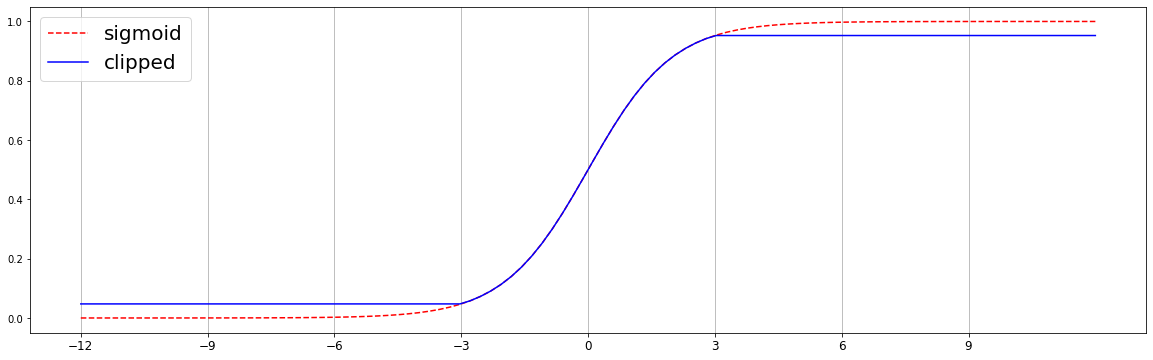

In [34]:
clipped_sigmoid(np.linspace(-12, 12, 100))

* $\text{The numpy clip function prevents the input from going outside a certain interval. }$


* $\text{This effectively avoids overflow in the exponential,}$ 
$\text{but also causes a small approximation error.}$

## $$\textbf{Frequent source of the overflows}$$
<hr>
<br>

$ \text{Many probability desity functions (pdfs) } p(x) \text{ for } x \in \mathbb R^D \text{ can be written as:}$
<hr>
<br>
$${
p(x) = \frac{\exp\Big(-E_{\theta}(x)\Big)}{Z(\theta)},\quad \text{where}\quad E_{\theta}(x): \mathbb R^{D} \rightarrow \mathbb R \quad \textit{( energy function )}
}$$

$${
Z(\theta) = \int_x \exp\Big(-E_{\theta}(x)\Big)\  dx, \quad \textit{( normalization constant )}
}$$
<br>

* $\text{Example of such pdfs: Gaussian, Multinomial, Exponential, Poisson...}$


* $\text{These functions have a risk of overflow due to the exponential function inside.}$

* $\text{Machine learning algorithms often use these distributions,}$
$\text{because their parameters can be learned easily.}$ 

$\text{For example:}$

$\quad \text{Mean parameter of a Gaussian distribution can be estimated by computing the empirical mean of the data,}$ 


$\quad \text{Scale parameter can be learned by the empirical standard deviation.}$




## $$\textbf{Unnormalized discrete density}$$
<hr>
<br> 

In [35]:
x = np.linspace(-2, 6, 100).astype(np.float32)

E = lambda x: (x - 2)**2/2
p = lambda x, Z = 1: np.exp(-E(x))/Z

In [39]:
def plot(x, p, Z=1):
    plt.figure(figsize=(12,6))
    plt.title('Unnormalized density', fontsize=25)
    plt.plot(x, p(x, Z), '.', linewidth=3)
    plt.grid()
    print(p(x, Z).sum())

31.017876


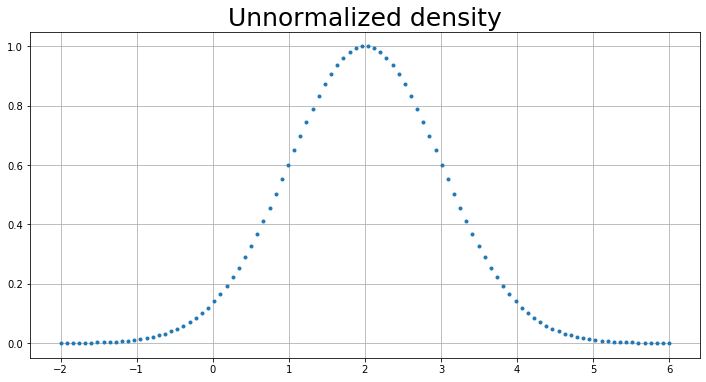

In [40]:
plot(x, p)

## $$\textbf{Normalized discrete density}$$
<hr>
<br> 

$$\sum_{x} p(x) = \frac{1}{Z(\theta)}\sum_{x} \exp\Big(-E_{\theta}(x)\Big) = 1\quad \Rightarrow\quad Z(\theta) = \sum_{x} \exp\Big(-E_{\theta}(x)\Big)$$

1.0000001 <class 'numpy.float32'>
True


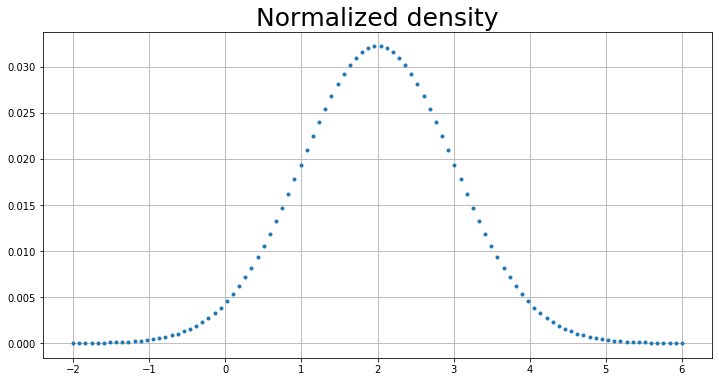

In [41]:
Z = p(x).sum()

plt.figure(figsize=(12,6))
plt.title('Normalized density', fontsize=25)
plt.plot(x, p(x, Z), '.',linewidth=3)
plt.grid()

val = p(x,Z).sum()
print(val, type(val))
print(np.isclose(1., val, rtol=1e-6))

#np.testing.assert_allclose(1., val)

## $$\textbf{Log-density function}$$
<hr>
<br> 

* $\text{Numerically stable pdf computation}$
<br>
<br>

$${\Large{
\ln p(x) = -  \ln Z(\theta) - E_{\theta}(x)
}}$$

## $$\textbf{Poisson probability mass function}$$
<hr>
<br> 

$$\Large{
p(k | \lambda) = {\frac{\lambda^k}{k !}} \exp(-\lambda), \quad k \geq 0
}$$

In [42]:
from scipy.special import factorial

def poisson_pmf(k, lambd):
    return lambd**k * np.exp(-lambd)/factorial(k) 

In [48]:
from scipy.stats import poisson

# Draw samples from Poisson distribution
lambd = 3

pos = poisson(lambd)
k =  np.sort(pos.rvs(500)) # drawing 500 samples from Poisson

idx = np.arange(len(k))
np.random.shuffle(idx)

print(k[idx[:10]]) #print ten random samples
print(np.mean(k))

[4 3 3 1 3 1 5 1 0 8]
2.994


In [56]:
def plot_poisson(k, pmf):
    plt.figure(figsize=(16,6))
    plt.xticks(np.arange(10))
    plt.title('Poisson mass function', fontsize=20)
    plt.hist(k, bins=20, density=True, width=0.6, alpha=0.5)
    plt.plot(k,  pmf, 's--', linewidth=3, c='r', label='$\lambda=$'+f'{lambd}', alpha=0.5)
    plt.legend(fontsize=20)
    plt.grid()

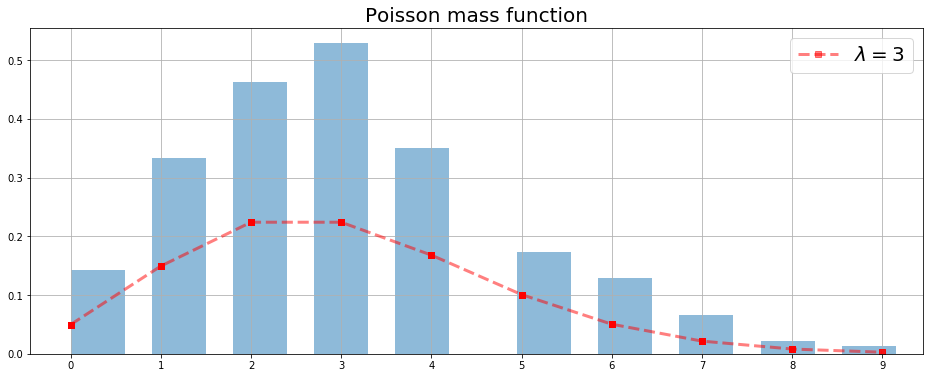

In [57]:
plot_poisson(k, poisson_pmf(k, lambd))

## $$\textbf{Poisson log-probability mass function}$$
<hr>
<br> 


In [60]:
large_k = 1000
poisson_pmf(large_k, lambd)

OverflowError: int too large to convert to float

$$\Large{
\ln p(k |\lambda) = k \ln \lambda - \ln{k !}  -\lambda , \quad k \geq 0 }
$$

<hr>
$$\Large{
k ! = \Gamma(k + 1), \quad \Gamma(x) = \int_{0}^{\infty} t^{x - 1}\exp^{-t} dt 
}$$

In [67]:
from scipy.special import loggamma

def log_poisson_pmf(k, lambd):
    assert np.all(k >= 0)
    return k*np.log(lambd) - loggamma(k + 1) - lambd 

In [73]:
log_poisson_pmf(large_k, lambd)

-4816.515889820054

In [72]:
log_pmf = log_poisson_pmf(k, lambd) 

np.allclose(pmf, np.exp(log_pmf))

True

## $$\textbf{Normalization constant of a log-density function}$$
<hr>
<br> 

* $\text{Numerically stable pdf computation}$
<br>
<br>

$${
0 = \ln \sum_{x} p(x) = \ln\bigg[ \frac{1}{Z(\theta)} \sum_{x} \exp {\Big(- E_{\theta}(x)\Big)}\bigg] = -\ln Z(\theta) + \ln\sum_{x} \exp(f(x))
}$$



$${
\ln Z(\theta) = \ln \underbrace{\sum_{x} \exp\Big(-E_{\theta}(x)\Big)}_{\text{sum of exp}}
}$$

## $$\textbf{Log-Sum-Exp trick}$$
<hr>
<br> 

* $\text{Given}\> x = \{x1, x2, \cdots, x_n\},\> \text{where}\> n \in \mathbb{N}$

$$ y = \ln \sum_{n=1}^N e^{x_n}\quad  \Rightarrow \quad e^y = \sum_{n=1}^N e^{x_n}$$

* $\text{Multiply both sides by}\> e^{-a} \neq 0 $
$$ e^{-a} e^y = e^{-a}\sum_{n=1}^N e^{x_n} \quad  \Rightarrow \quad e^{y-a} = \sum_{n=1}^N e^{x_n - a}$$

$$ {y-a} = \ln \sum_{n=1}^N e^{x_n - a} \quad  \Rightarrow \quad y = a + \ln \sum_{n=1}^N e^{x_n - a} $$

$$\boxed{y = \ln \sum_{n=1}^N e^{x_n} = a + \ln \sum_{n=1}^N e^{x_n - a},\quad a = \max(x_i),\quad i = \overline{1,\cdots,N}}$$

## $$\textbf{Working with source data efficiently}$$
<hr>
<br> 


<center>
    <img src='./images/pan.png' width=500>    
</center>

## $$\textbf{Data Series}$$
<hr>
<br> 

* $\text{Specialization of } \textbf{Python} \text{ dictionary.}$

In [9]:
# conda install -c anaconda pandas

import pandas as pd
import numpy as np

In [10]:
lst = [0, 2, 4., 6]
data = pd.Series(lst, index = 10*np.arange(len(lst))) # arbitraty index could be used
data

0     0.0
10    2.0
20    4.0
30    6.0
dtype: float64

In [11]:
type(data), data.index, data.values

(pandas.core.series.Series,
 Int64Index([0, 10, 20, 30], dtype='int64'),
 array([0., 2., 4., 6.]))

In [12]:
# Indexing

print(data[10]) # getting one element
print(10*'=')
print(data[:2]) # slices
print(10*'=')
print(data[[True, False, True, False]]) # using a boolen mask

2.0
0     0.0
10    2.0
dtype: float64
0     0.0
20    4.0
dtype: float64


## $$\textbf{Data Series from Dictionary}$$
<hr>
<br> 

In [13]:
dct = { 3 : 'three', 1 : 'one', 2 : 'two', 0 : 'zero'}

pd.Series(dct)

3    three
1      one
2      two
0     zero
dtype: object

In [14]:
pd.Series(dct, index = [3, 2, 0]) # keys to be taken from the dict

3    three
2      two
0     zero
dtype: object

## $$\textbf{Data Frame}$$
<hr>
<br> 

* $\text{Generalization of a } NumPy \ 2d\text{-array with both flexible row and
column names}$

In [18]:
ages_dct = {'Anna': 19, 'Bob': 28, 'Carl': 23}
ages = pd.Series(ages_dct)

iqs_dct = {'Anna': 129, 'Bob': 117, 'Carl': 123}
iqs = pd.Series(iqs_dct)

In [19]:
persons = {'age' : ages, 'iq' : iqs}
persons = pd.DataFrame(persons) # from dict
persons

,age,iq
Anna,19,129
Bob,28,117
Carl,23,123


In [20]:
print(persons.index)
print(10*'=')
print(persons.columns)

Index(['Anna', 'Bob', 'Carl'], dtype='object')
Index(['age', 'iq'], dtype='object')


## $$\textbf{Reading Data from a File}$$
<hr>
<br> 

In [25]:
presidents = pd.read_csv('./data/president_heights.csv')

In [43]:
presidents.head(10)

,order,name,height(cm)
0,1,George Washington,189
1,2,John Adams,170
2,3,Thomas Jefferson,189
3,4,James Madison,163
4,5,James Monroe,183
5,6,John Quincy Adams,171
6,7,Andrew Jackson,185
7,8,Martin Van Buren,168
8,9,William Henry Harrison,173
9,10,John Tyler,183


In [33]:
headers = ['user_id', 'movie_id', 'rating', 'timestamp']
movies = pd.read_csv('./data/u.data', delimiter='\t', names=headers)

In [35]:
movies.tail(5)

,user_id,movie_id,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


## $$\textbf{Get info about the loaded data}$$
<hr>
<br> 

In [68]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id      100000 non-null int64
movie_id     100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


## $$\textbf{Get statistics}$$
<hr>
<br> 

In [42]:
# get general statistics

movies.describe()

,user_id,movie_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [40]:
# summary of the values over one specific columns

movies.rating.value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

## $$\textbf{Retrieve the specified rows}$$
<hr>
<br> 

In [48]:
movies.loc[10:20]

,user_id,movie_id,rating,timestamp
10,62,257,2,879372434
11,286,1014,5,879781125
12,200,222,5,876042340
13,210,40,3,891035994
14,224,29,3,888104457
15,303,785,3,879485318
16,122,387,5,879270459
17,194,274,2,879539794
18,291,1042,4,874834944
19,234,1184,2,892079237


In [49]:
movies.loc[[123, 242, 153]]

,user_id,movie_id,rating,timestamp
123,44,195,5,878347874
242,286,171,4,877531791
153,269,504,4,891449922


## $$\textbf{Filtering}$$
<hr>
<br> 

In [63]:
high_ratings = movies[movies.rating > 3] # equiv. by a key movies[movies['rating'] > 3] 
len(high_ratings)

55375

In [64]:
movie_7 = movies[movies.movie_id == 7]
movie_7.head(3)

,user_id,movie_id,rating,timestamp
256,250,7,4,878089716
606,10,7,4,877892210
1597,66,7,3,883601355


In [65]:
movie_7.rating.mean()

3.798469387755102

## $$\textbf{Sorting}$$
<hr>
<br> 

In [67]:
movies.sort_values('rating', ascending=False)

,user_id,movie_id,rating,timestamp
28336,64,183,5,889737914
16000,213,121,5,878870940
28426,286,707,5,877531975
38655,94,518,5,891720950
16022,108,10,5,879879834
...,...,...,...,...
27329,13,401,1,882141841
27316,405,788,1,885548275
27307,279,1266,1,875308843
85465,68,926,1,876974298


## $$\textbf{Grouping}$$
<hr>
<br> 

In [81]:
r_counts = movies.groupby('rating').count()
r_counts

,user_id,movie_id,timestamp
rating,,,
1,6110,6110,6110
2,11370,11370,11370
3,27145,27145,27145
4,34174,34174,34174
5,21201,21201,21201


In [82]:
r_counts[['movie_id', 'user_id']]

,movie_id,user_id
rating,,
1,6110,6110
2,11370,11370
3,27145,27145
4,34174,34174
5,21201,21201


## $$\textbf{Google colab}$$
<hr>
<br> 

<center>
    <img src='./images/colab.png' width=500>    
</center>

# $$\textbf{Thank you for your attention !}$$